In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl

plt.rcParams["figure.dpi"] = 300

In [2]:
@dataclass
class CalibrationValues:
    v: float  # voltage during measurement in open air (20.95% O2)
    v_0: float  # voltage during measurement in N2
    p: float  # pressure, kPa
    rh: float  # relative humidity, %
    t: float  # temperature, C

    @property
    def cf(self):  # calibration factor
        return (0.2095 * self.p) / (self.v - self.v_0)


oxy1_dry = CalibrationValues(0.052950695, 0.001456225, 99.99825, 4.75015, 22.02595)
oxy1_wet = CalibrationValues(0.05166569, 0.001474925, 100.044045, 100.0, 22.5211)
oxy2_dry = CalibrationValues(0.05059791, 0.00150478, 99.99825, 4.75015, 22.6997)
oxy2_wet = CalibrationValues(0.04897935, 0.00153704, 100.044045, 100.0, 23.3594)

# convert oxygen sensors voltage to oxygen %
def oxy_volt_to_percent(
    volt: float,
    temp: float,
    pressure: float,
    humidity: float,
    cal: CalibrationValues,
    assume_zero_RH: bool = False,
) -> float:
    p_vapor = (
        lambda t, rh: (rh / 100)
        * 0.61121
        * np.exp(t * (18.678 - t / 234.5) / (t + 257.14))
    )
    c1, c2, c3 = -0.06949, 0.001422, -0.0000008213
    if assume_zero_RH:
        humidity = 0
    oxy_percent = cal.cf * (volt - cal.v_0) * (cal.p / pressure) * (
        (cal.p + p_vapor(temp, humidity) - p_vapor(cal.t, cal.rh)) / cal.p
    ) + (
        c3 * temp**3
        + c2 * temp**2
        + c1 * temp
        - c3 * cal.t**3
        - c2 * cal.t**2
        - c1 * cal.t
    )
    return oxy_percent


def df_oxy_volt_to_percent(
    df: pd.DataFrame,
    sensor: str,  # "oxy1" or "oxy2"
    cal: CalibrationValues,
    assume_zero_RH: bool = False,
):
    volt_col = {"oxy1": "oxy1_voltage (V)", "oxy2": "oxy2_voltage (V)"}[sensor]
    temp_col = {"oxy1": "oxy1_temp (C)", "oxy2": "oxy2_temp (C)"}[sensor]
    oxy_col = {"oxy1": "oxy1_O2 (%)", "oxy2": "oxy2_O2 (%)"}[sensor]
    df[oxy_col] = oxy_volt_to_percent(
        df[volt_col],
        df[temp_col],
        df["pressure (kPa)"],
        df["humidity (%)"],
        cal,
        assume_zero_RH,
    )

In [4]:
data = pd.read_csv("./data/RXN00026.csv", skiprows=4)
data["elapsed_time"] = data["time (s)"] - data["time (s)"].iloc[0]

df_oxy_volt_to_percent(data, "oxy1", oxy1_dry, assume_zero_RH=True)
df_oxy_volt_to_percent(data, "oxy2", oxy2_dry, assume_zero_RH=True)
data

,time (s),oxy1_voltage (V),oxy1_O2 (%),oxy1_temp_voltage (V),oxy1_temp (C),oxy2_voltage (V),oxy2_O2 (%),oxy2_temp_voltage (V),oxy2_temp (C),bme_temp (C),...,PV (C),SV (C),Control Method,Output,PID profile,PID SV,P,I,D,elapsed_time
0,1653737709,0.001375,-0.028078,1.076750,21.47,0.048797,20.140568,1.057125,22.08,20.95,...,50.2,50.0,0,0,3,110.0,336,162,40,0
1,1653737710,0.001375,-0.028078,1.077000,21.47,0.048797,20.140647,1.057250,22.07,20.95,...,50.2,50.0,0,231,3,110.0,336,162,40,1
2,1653737711,0.001375,-0.027983,1.077125,21.46,0.048797,20.140647,1.057250,22.07,20.95,...,50.2,50.0,0,231,3,110.0,336,162,40,2
3,1653737712,0.001375,-0.028078,1.077000,21.47,0.048781,20.133835,1.057250,22.07,20.96,...,50.3,50.0,0,231,3,110.0,336,162,40,3
4,1653737713,0.001375,-0.028078,1.077000,21.47,0.048812,20.147034,1.057250,22.07,20.96,...,50.3,50.0,0,231,3,110.0,336,162,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,1653746339,0.018437,6.898776,1.046625,22.40,0.012641,4.747360,1.037250,22.69,21.40,...,318.2,320.0,0,1000,1,320.0,122,93,23,8630
8618,1653746340,0.018422,6.892679,1.046625,22.40,0.012656,4.753754,1.037250,22.69,21.40,...,318.2,320.0,0,1000,1,320.0,122,93,23,8631
8619,1653746341,0.018437,6.898846,1.046875,22.39,0.012656,4.753754,1.037375,22.69,21.40,...,318.2,320.0,0,1000,1,320.0,122,93,23,8632
8620,1653746342,0.018422,6.892679,1.046625,22.40,0.012641,4.747360,1.037375,22.69,21.40,...,318.2,320.0,0,1000,1,320.0,122,93,23,8633


In [5]:
# create column for flow rate that only uses the active sensor
# note: this might run into problems if you change the active sensor, specifically in the transition region
flow = pd.DataFrame()
flow["flow1"] = data["flow1_flow (mL/min)"].mask(data["flow1_voltage (V)"] < 0.1, 0)
flow["flow2"] = data["flow2_flow (mL/min)"].mask(data["flow2_voltage (V)"] < 0.1, 0)
flow["flow"] = flow["flow1"] + flow["flow2"]
data["flow"] = flow["flow"]

# remove oxygen data where flow is zero
data["oxy1_O2 (%)"].mask(data["flow"] == 0, inplace=True)
data["oxy2_O2 (%)"].mask(data["flow"] == 0, inplace=True)

# replace 0 with NaN so it doesn't get plotted
data["flow"].mask(data["flow"] == 0, inplace=True)
data["oxy1_O2 (%)"].mask(data["oxy1_O2 (%)"] == 0, inplace=True)
data["oxy2_O2 (%)"].mask(data["oxy2_O2 (%)"] == 0, inplace=True)

In [7]:
# create log of changes made using temperature controller
control_method = {0: "PID", 1: "ON/OFF", 2: "Manual", 3: "PID Program Control"}

change_log = []
prev_ctrl = ""
prev_pid_profile = ""
for row in data.iterrows():
    if row[1]["Control Method"] != prev_ctrl:
        change_log.append(
            (
                row[0],
                row[1]["elapsed_time"],
                f'Control method changed to {control_method[int(row[1]["Control Method"])]}',
            )
        )
    if row[1]["PID profile"] != prev_pid_profile:
        change_log.append(
            (
                row[0],
                row[1]["elapsed_time"],
                f'PID profile changed to {int(row[1]["PID profile"])}',
            )
        )
    prev_ctrl = row[1]["Control Method"]
    prev_pid_profile = row[1]["PID profile"]
change_log

[(0, 0.0, 'Control method changed to PID'),
 (0, 0.0, 'PID profile changed to 3'),
 (2909, 2913.0, 'PID profile changed to 1'),
 (2918, 2922.0, 'Control method changed to PID Program Control'),
 (6771, 6781.0, 'Control method changed to PID')]

Text(1.175, 0.75, 'Log: \n0 min: Control method changed to PID\n0 min: PID profile changed to 3\n48 min: PID profile changed to 1\n48 min: Control method changed to PID Program Control\n113 min: Control method changed to PID\n\nPID 3: SV = 110.0, P = 336.0, I = 162.0, D = 40.0\nPID 1: SV = 320.0, P = 122.0, I = 93.0, D = 23.0\n')

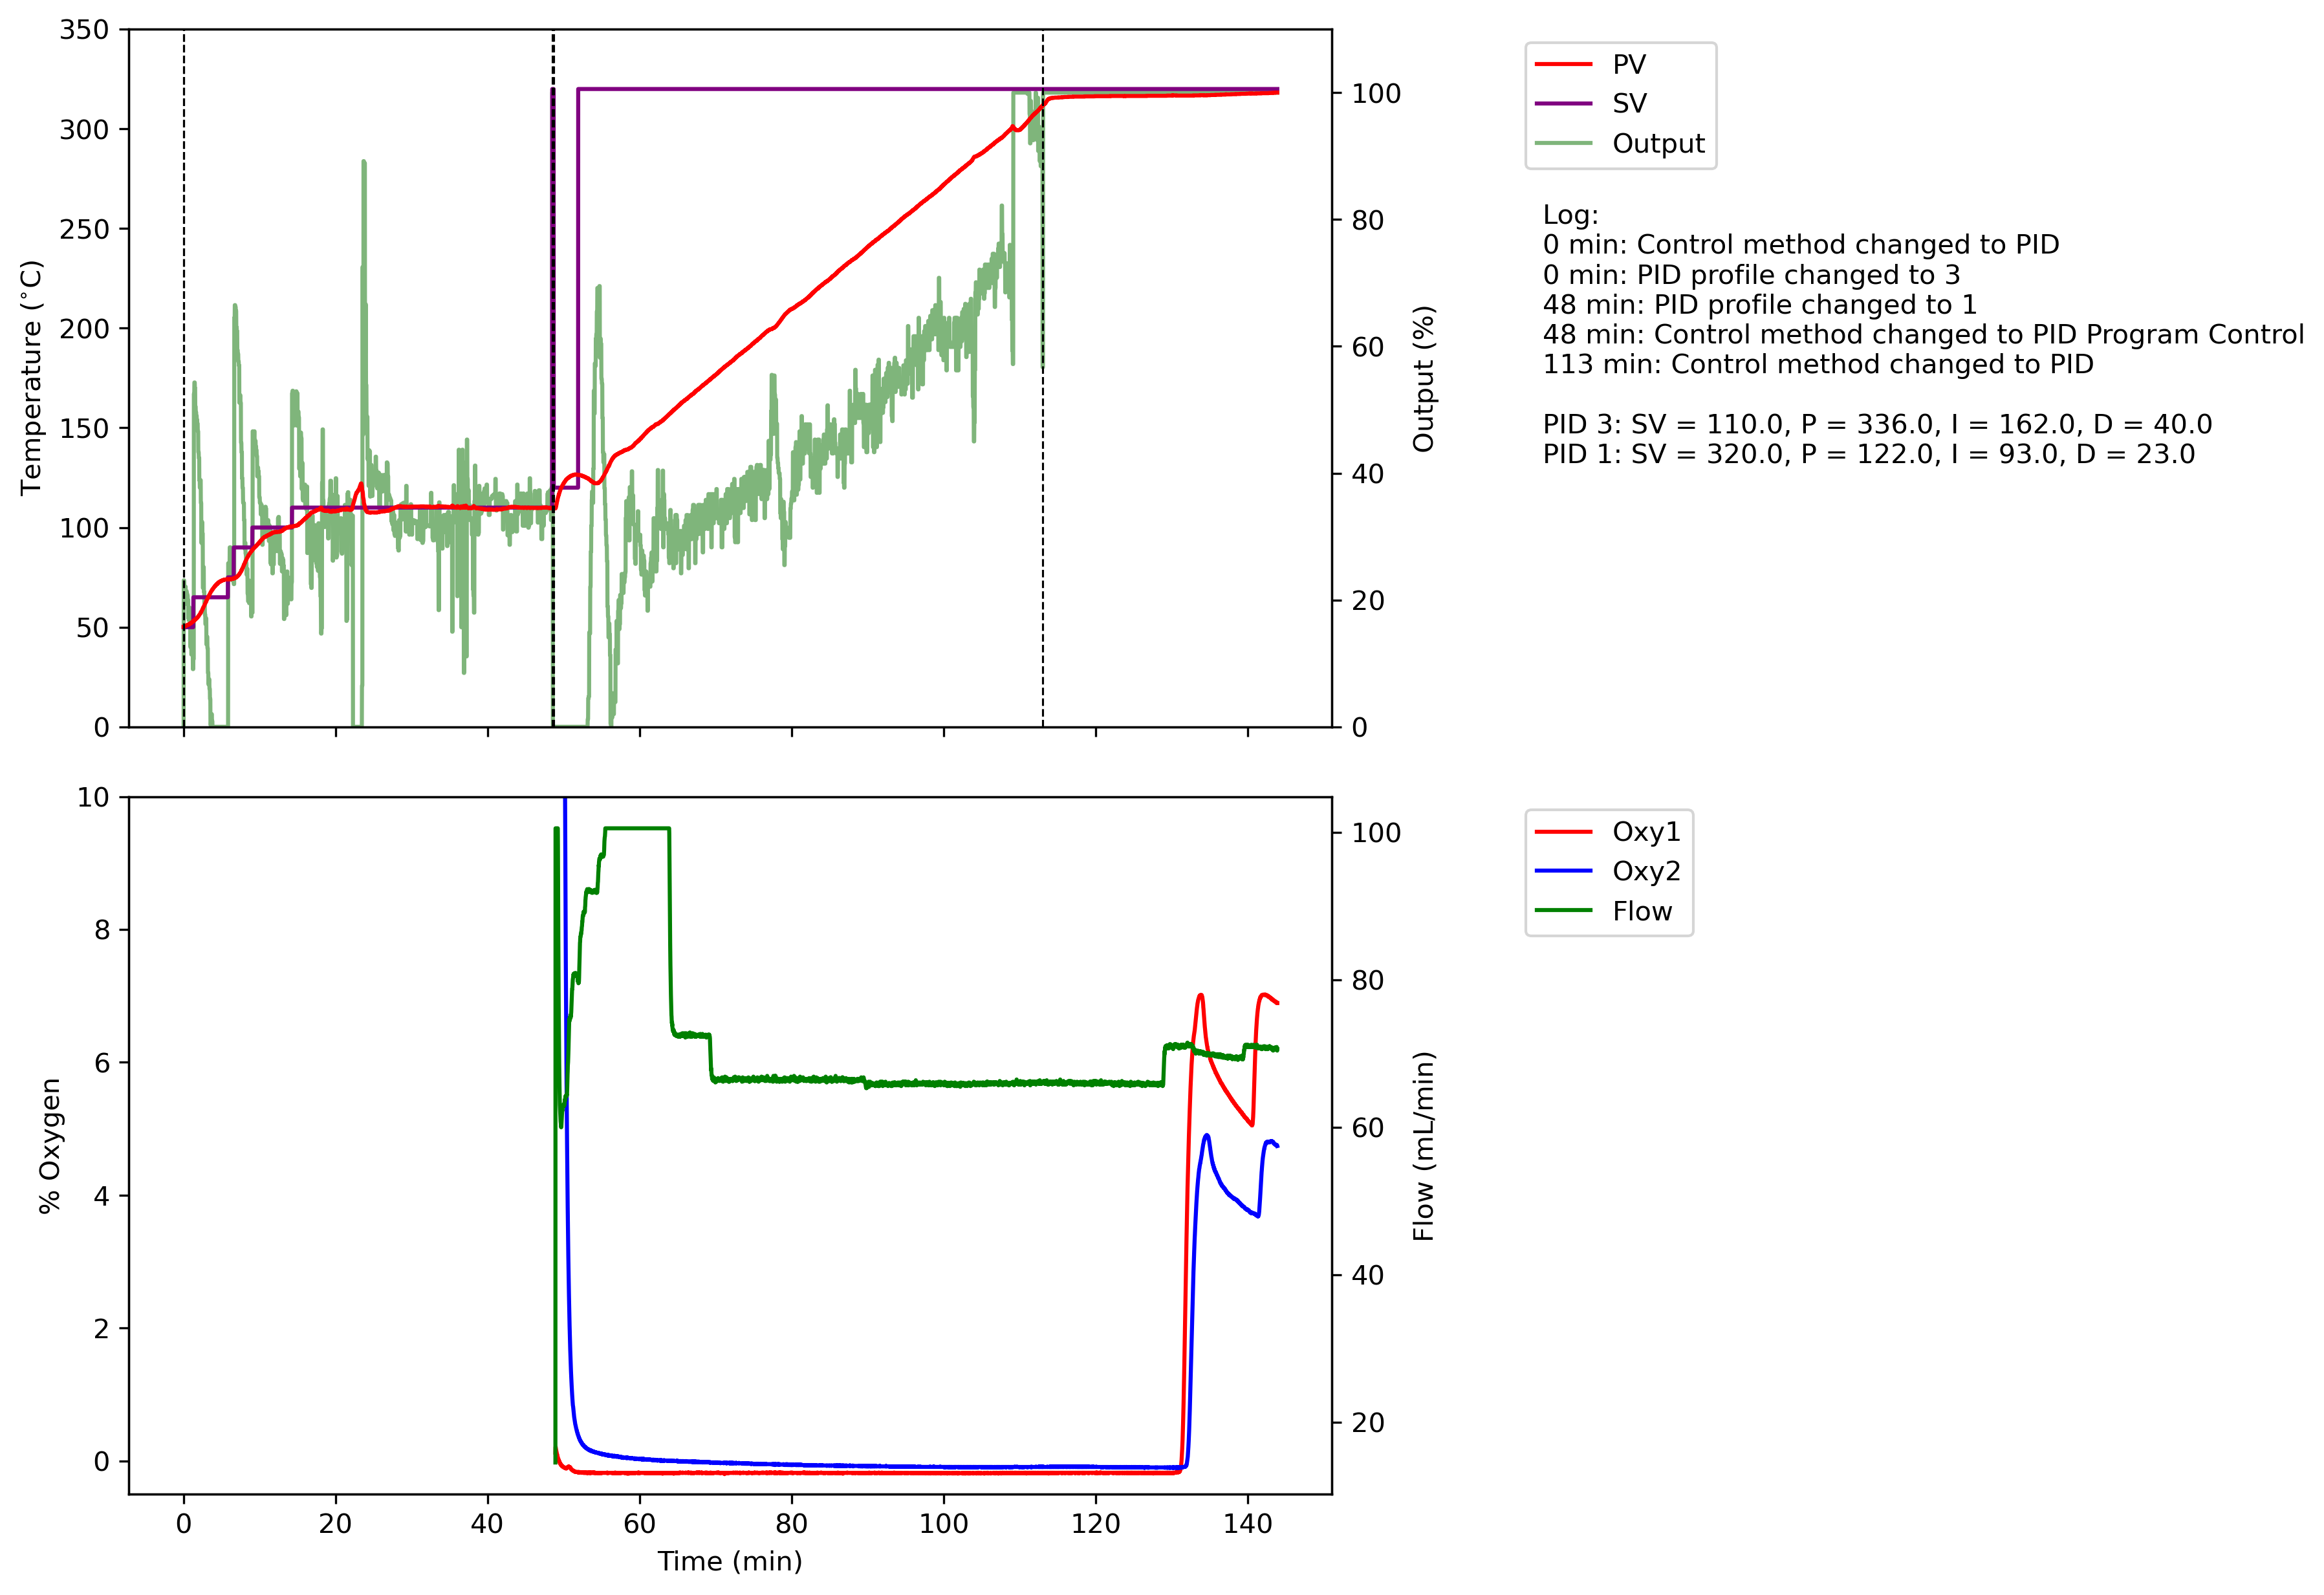

In [8]:
fig, (ax1a, ax2a) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
plt.subplots_adjust(hspace=0.1)
# ax1a.set_title("Reaction X", fontsize=16)
ax2a.set_xlabel("Time (min)")
ax1a.set_ylabel("Temperature ($^{\circ}$C)")
ax1a.set_ylim(0, 350)
ax1b = ax1a.twinx()
ax1b.set_ylabel("Output (%)")
ax1b.set_ylim(0, 110)
ax2a.set_ylabel("% Oxygen")
ax2b = ax2a.twinx()
ax2b.set_ylabel("Flow (mL/min)")
ax1_ln1 = ax1a.plot(
    data["elapsed_time"] / 60, data["PV (C)"], label="PV", c="red", zorder=2
)
ax1_ln2 = ax1a.plot(
    data["elapsed_time"] / 60, data["SV (C)"], label="SV", c="purple", zorder=1
)
ax1_ln3 = ax1b.plot(
    data["elapsed_time"] / 60, data["Output"] / 10, label="Output", c="#7fb57b"
)
ax2_ln1 = ax2a.plot(
    data["elapsed_time"] / 60, data["oxy1_O2 (%)"], label="Oxy1", c="red"
)
ax2_ln2 = ax2a.plot(
    data["elapsed_time"] / 60, data["oxy2_O2 (%)"], label="Oxy2", c="blue"
)
ax2_ln3 = ax2b.plot(data["elapsed_time"] / 60, data["flow"], label="Flow", c="green")
ax2a.set_ylim(-0.5, 10)
ax1_lns = ax1_ln1 + ax1_ln2 + ax1_ln3
ax1_labels = [l.get_label() for l in ax1_lns]
ax2_lns = ax2_ln1 + ax2_ln2 + ax2_ln3
ax2_labels = [l.get_label() for l in ax2_lns]
ax1_legend = ax1a.legend(
    ax1_lns, ax1_labels, loc="upper left", bbox_to_anchor=(1.15, 1)
)
ax2_legend = ax2a.legend(
    ax2_lns, ax2_labels, loc="upper left", bbox_to_anchor=(1.15, 1)
)
ax1b.set_zorder(1)
ax1a.set_zorder(2)
ax1a.patch.set_visible(False)

for entry in change_log:
    ax1a.axvline(x=entry[1] / 60, color="black", linestyle="--", linewidth=0.75)
text = "Log: \n"
for entry in change_log:
    text += f"{int(entry[1]/60)} min: {entry[2]}\n"
text += "\n"
for profile in data["PID profile"].unique():
    sv = data[data["PID profile"] == profile]["PID SV"].iloc[0]
    p = data[data["PID profile"] == profile].iloc[0]["P"]
    i = data[data["PID profile"] == profile].iloc[0]["I"]
    d = data[data["PID profile"] == profile].iloc[0]["D"]
    text += f"PID {profile}: SV = {sv}, P = {p}, I = {i}, D = {d}\n"
ax1a.text(
    1.175,
    0.75,
    text,
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax1a.transAxes,
)